In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np

from typing import Optional

In [3]:
DTYPE = torch.float32
DEVICE = torch.device("cuda")

# Load NeRF Data

In [4]:
DATA_PATH = 'data/'

In [5]:
from load_blender import load_blender_data
LEGO_DIR = os.path.join(DATA_PATH, "nerf_synthetic", "lego")

# reduce the image resolution by half_res
# load part of the whole dataset

images, poses, render_poses, [H, W, focal], i_split, bounding_box = load_blender_data(basedir=LEGO_DIR, half_res=True, testskip=4)

In [6]:
# Convert useful variables to tensors
images = torch.from_numpy(np.asarray(images)).to(device=DEVICE, dtype=DTYPE)
poses = torch.from_numpy(np.asarray(poses)).to(device=DEVICE, dtype=DTYPE)
focal = torch.from_numpy(np.asarray(focal)).to(device=DEVICE, dtype=DTYPE)

In [7]:
images.shape, poses.shape, poses[0], render_poses.shape, render_poses[0], H, W, focal, len(i_split), i_split

(torch.Size([175, 400, 400, 4]),
 torch.Size([175, 4, 4]),
 tensor([[-9.9990e-01,  4.1922e-03, -1.3346e-02, -5.3798e-02],
         [-1.3989e-02, -2.9966e-01,  9.5394e-01,  3.8455e+00],
         [-4.6566e-10,  9.5404e-01,  2.9969e-01,  1.2081e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0'),
 torch.Size([40, 4, 4]),
 tensor([[ 1.0000e+00,  6.1232e-17, -1.0606e-16, -4.2423e-16],
         [-1.2246e-16,  5.0000e-01, -8.6603e-01, -3.4641e+00],
         [ 0.0000e+00,  8.6603e-01,  5.0000e-01,  2.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]),
 400,
 400,
 tensor(555.5555, device='cuda:0'),
 3,
 [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
         68, 69, 70, 71, 72, 73

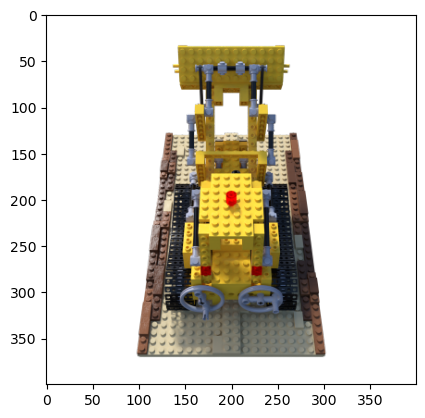

In [8]:
# show the first test image
plt.imshow(images[len(i_split[0])+len(i_split[1])].detach().cpu().numpy())
plt.show()

# Ray representation

### Get a bundle of rays.
Here we define a function, which takes the height & width of the image, focal length and camera-to-world transformation matrix as input. The function outputs a set of origin points and direction vectors, which could be used to describe rays shooting out from image pixels.

`Compute rays passing through all pixels of an image

H: Height of an image

W: Width of an image

G: Focal length of camera

cam2world: A 6-DoF rigid-body transform (4x4 matrix) that transforms a 3D point  from the camera frame to the world frame (in homogeneous coordinate)
    
ray_origins: A tensor of shape (H, W, 3) denoting the centers of each ray.

ray_origins[i][j] denotes the origin of the ray passing through pixel at row index 'i' and column index 'j'.

ray_directions: A tensor of shape (H, W, 3) denoting the direction of each ray.

ray_directions[i][j] denotes the direction (x, y, z) of the ray passing through the pixel at row index 'i' and column index 'j'


In [9]:
img_idx = 0
i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H), indexing='xy')
print(i)
# same type & device as poses[0]
i = i.to(poses[img_idx]) # (H, W)
j = j.to(poses[img_idx]) # (H, W)
print(poses[img_idx])

tensor([[  0.,   1.,   2.,  ..., 397., 398., 399.],
        [  0.,   1.,   2.,  ..., 397., 398., 399.],
        [  0.,   1.,   2.,  ..., 397., 398., 399.],
        ...,
        [  0.,   1.,   2.,  ..., 397., 398., 399.],
        [  0.,   1.,   2.,  ..., 397., 398., 399.],
        [  0.,   1.,   2.,  ..., 397., 398., 399.]])
tensor([[-9.9990e-01,  4.1922e-03, -1.3346e-02, -5.3798e-02],
        [-1.3989e-02, -2.9966e-01,  9.5394e-01,  3.8455e+00],
        [-4.6566e-10,  9.5404e-01,  2.9969e-01,  1.2081e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


In [10]:
directions = torch.stack([(i - W * .5) / focal,
                              -(j - H * .5) / focal,
                              -torch.ones_like(i, device=DEVICE)] , dim=-1) # (H, W, 3)
directions

tensor([[[-0.3600,  0.3600, -1.0000],
         [-0.3582,  0.3600, -1.0000],
         [-0.3564,  0.3600, -1.0000],
         ...,
         [ 0.3546,  0.3600, -1.0000],
         [ 0.3564,  0.3600, -1.0000],
         [ 0.3582,  0.3600, -1.0000]],

        [[-0.3600,  0.3582, -1.0000],
         [-0.3582,  0.3582, -1.0000],
         [-0.3564,  0.3582, -1.0000],
         ...,
         [ 0.3546,  0.3582, -1.0000],
         [ 0.3564,  0.3582, -1.0000],
         [ 0.3582,  0.3582, -1.0000]],

        [[-0.3600,  0.3564, -1.0000],
         [-0.3582,  0.3564, -1.0000],
         [-0.3564,  0.3564, -1.0000],
         ...,
         [ 0.3546,  0.3564, -1.0000],
         [ 0.3564,  0.3564, -1.0000],
         [ 0.3582,  0.3564, -1.0000]],

        ...,

        [[-0.3600, -0.3546, -1.0000],
         [-0.3582, -0.3546, -1.0000],
         [-0.3564, -0.3546, -1.0000],
         ...,
         [ 0.3546, -0.3546, -1.0000],
         [ 0.3564, -0.3546, -1.0000],
         [ 0.3582, -0.3546, -1.0000]],

        [[

Note:

We use homogeneous coordinate for transformation. Each point in the 3D space
could be represent as [x, y, z, 1]. With cam2world @ [x, y, z, 1].T, we
are transfomring that point from camera fram to the world frame.
Besides, the origin point of the camera frame is [0, 0, 0, 1]. we could 
get world-frame coordinate of that origin with pose[1] @ [0, 0, 0, 1].T,
which turns out to be pose[1][:3, -1].


In [11]:
# Apply transformation to the direction, f(d) = Ad = dA^(T)
ray_directions = directions @ poses[img_idx][:3, :3].t() # (H, W, 3)

#  All the rays share the same origin -> camera pinhole in world frame
ray_origins = poses[img_idx][:3, -1].expand(ray_directions.shape) # (H, W, 3)
print(ray_origins.shape, ray_directions.shape)
print(ray_origins.device, ray_origins.dtype)
print(ray_directions[0][0])

torch.Size([400, 400, 3]) torch.Size([400, 400, 3])
cuda:0 torch.float32
tensor([ 0.3748, -1.0568,  0.0438], device='cuda:0')


# Stratified Sampling
During volume rendering, the original paper states that the color observed by the camera could be calculated by volume rendering equation, which get the integral along the rays. In order to speed up the calculation, we approximate integrals with a set of sampled 3D points on the rays.

We assume that a near and a far clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. Then we sample 3D points along each ray. Sample a set of 3D points given the bundle of rays

In [12]:
num_samples = 4
near_point = 2
far_point = 6

In [13]:
# Partition each ray length between [near, far] into N evenly-spaced bins (H, W, num_samples)
depth_scalars = torch.linspace(near_point, far_point, num_samples).to(ray_origins)
print(depth_scalars)
depth_scalars = depth_scalars.expand(H, W, num_samples)
print(depth_scalars)

tensor([2.0000, 3.3333, 4.6667, 6.0000], device='cuda:0')
tensor([[[2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000],
         ...,
         [2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000]],

        [[2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000],
         ...,
         [2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000]],

        [[2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000],
         ...,
         [2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000]],

        ...,

        [[2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.3333, 4.6667, 6.0000],
         [2.0000, 3.

In [14]:
# Then draw one sample uniformly at random from within each bin
# If we want to randomly sampled along each ray, we add a uniform noise to the bin intervals 
# in order to make sure certain uniformity among them, notice that
# we randomize for each ray (the noises are not the same for all the rays)
# We randomly sample noice in [0, 1), shape (H, W, num_samples)
noise = torch.rand(H, W, num_samples).to(ray_origins)

# Normalize the noise by uniform distance among samples
noise = noise * (far_point - near_point) / num_samples

# Add noise to depth value, get shape (H, W, num_samples)
depth_scalars = depth_scalars + noise
print(depth_scalars.shape)
print(depth_scalars[0])

torch.Size([400, 400, 4])
tensor([[2.9700, 4.0313, 5.4845, 6.5002],
        [2.7545, 3.5124, 5.3644, 6.0980],
        [2.7442, 3.6846, 5.2525, 6.2388],
        ...,
        [2.8352, 4.2713, 5.2678, 6.2746],
        [2.0268, 3.3966, 4.8652, 6.2758],
        [2.8283, 4.2600, 5.0458, 6.2207]], device='cuda:0')


In [15]:
# Note: ray_directions all have different lengths, but are all close to 1,
#       we don't transfer them to unit vector for simplicity (?)
# (H, W, num_samples, 3) = (H, W, 1, 3) + (H, W, 1, 3) * (H, W, num_samples, 1)
# sample point on ray (point) = ray origin (point) + ray direction (vector) * t (scalars)
# so for each ray make some copies of number of sample points to multiply their respective scalar with direction

Two tensors are “broadcastable” if the following rules hold:

Each tensor has at least one dimension.

When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, **`one of them is 1`**, or one of them does not exist.

In [16]:
print(ray_directions[..., None, :].shape)
print(depth_scalars[..., :, None].shape)
# copy the rays 4 times for each scalar, copy scalars 3 times for each axis

torch.Size([400, 400, 1, 3])
torch.Size([400, 400, 4, 1])


In [17]:
sampled_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_scalars[..., :, None]
print(sampled_points.shape)
print(sampled_points[0][0])

torch.Size([400, 400, 4, 3])
tensor([[ 1.0594,  0.7069,  1.3381],
        [ 1.4572, -0.4147,  1.3845],
        [ 2.0019, -1.9504,  1.4481],
        [ 2.3826, -3.0238,  1.4926]], device='cuda:0')


# Positional Encoding

The encoding function used by original paper (section 5.1), which map each sampled point on the rays from R3 to a higher dimensional space R^2L or R^(2L+1) (we might include input in positional encoding):

$enc(x) = x, sin(2^0 x), cos(2^0 x), sin(2^1 x), cos(2^1 x),..., sin(2^L-1 x), cos(2^L-1 x)$

Apply positional encoding to the input. (Section 5.1 of original paper)
We use positional encoding to map continuous input coordinates into a higher dimensional space to enable our MLP to more easily approximate a higher frequency function.

pos_in: input tensor to be positionally encoded, (H*W*num_samples, 3) for sampled point

num_freq: mapping from R into a higher dimensional space $\mathbb{R}^{2L}$, in which L is called the frequency

include_input: whether or not to include the input in positional encoding

log_sampling: sample logarithmically in frequency space, otherwise linearly

pos_out: positional encoding of the input tensor.

pose_out shape: $(H*W*num samples, (include input + 2*num freq) * 3)$

In [18]:
flattened_sampled_points = sampled_points.reshape((-1, 3))

In [19]:
print(flattened_sampled_points.shape)

torch.Size([640000, 3])


In [20]:
num_freq=3
include_input=True
log_sampling=True

In [21]:
# Whether or not include the input in positional encoding
pos_out = [flattened_sampled_points] if include_input else []
print(pos_out)

# Shape of freq_bands: (num_freq)
if log_sampling:
    freq_bands = 2.0 ** torch.linspace(0.0, num_freq - 1, num_freq).to(flattened_sampled_points)
else:
    freq_bands = torch.linspace(2.0 ** 0.0, 2.0 ** (num_freq - 1), num_freq).to(flattened_sampled_points)
print(freq_bands)

for freq in freq_bands:
    pos_out.extend(func(flattened_sampled_points * freq) for func in [torch.sin, torch.cos])

pos_out = torch.cat(pos_out, dim=-1)
print(pos_out)
print(pos_out.shape) # 3 (x,y,z) + 2 (sin,cos) * 9 (#freq * (x,y,z))

[tensor([[ 1.0594,  0.7069,  1.3381],
        [ 1.4572, -0.4147,  1.3845],
        [ 2.0019, -1.9504,  1.4481],
        ...,
        [-1.2417,  0.9245, -0.9920],
        [-1.8746, -0.6320, -2.1643],
        [-2.4496, -2.0459, -3.2292]], device='cuda:0')]
tensor([1., 2., 4.], device='cuda:0')
tensor([[ 1.0594,  0.7069,  1.3381,  ..., -0.4572, -0.9511,  0.5971],
        [ 1.4572, -0.4147,  1.3845,  ...,  0.8985, -0.0879,  0.7350],
        [ 2.0019, -1.9504,  1.4481,  ..., -0.1529,  0.0523,  0.8820],
        ...,
        [-1.2417,  0.9245, -0.9920,  ...,  0.2515, -0.8493, -0.6776],
        [-1.8746, -0.6320, -2.1643,  ...,  0.3480, -0.8176, -0.7196],
        [-2.4496, -2.0459, -3.2292,  ..., -0.9310, -0.3237,  0.9392]],
       device='cuda:0')
torch.Size([640000, 21])


# MLP Model
The model takes 3D input (encoded xyz coordinates), which is different from the 5D input used in original paper (which includes view directions, in addition to xyz coordinates)

In [22]:
from torch import nn
from torch.nn import functional as F

class MLPNeRF(torch.nn.Module):
    def __init__(self, pos_dim, fc_dim=128):
      super().__init__()

      self.nerf = nn.Sequential(
                    nn.Linear(pos_dim, fc_dim),
                    nn.ReLU(),
                    nn.Linear(fc_dim, fc_dim),
                    nn.ReLU(),
                    nn.Linear(fc_dim, 4)
                  )
    
    def forward(self, x):
      x = self.nerf(x)
      return x

In [23]:
pos_dim = pos_out.shape[-1]
model = MLPNeRF(pos_dim, fc_dim=128)
model.cuda()

MLPNeRF(
  (nerf): Sequential(
    (0): Linear(in_features=21, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)

# Volume Rendering
We feed the x,y,z coordinate to out MLP model, which consists of fully connected layer. The model forward returns predicted RGB color and predicted volume density for each sampled point on the rays.

In [24]:
radiance_field = model(pos_out)
print(radiance_field.shape)
radiance_field = radiance_field.view(H, W, num_samples, 4)
print(radiance_field[0][0]) # (r g b σ) for the 4 sampled points on the ray at pixel towards (0,0)

torch.Size([640000, 4])
tensor([[ 0.0226, -0.1390, -0.1005, -0.0551],
        [ 0.0126, -0.0700, -0.1420, -0.0085],
        [ 0.0173, -0.1572, -0.1449,  0.0249],
        [ 0.0763, -0.1882, -0.2294,  0.0446]], device='cuda:0',
       grad_fn=<SelectBackward0>)


Color observed by the camera could be calculated by volume rendering equation:
$$C(r) = \int_{t_{near}}^{t_{far}} T(t) \sigma (r(t))c(r(t), d),\mathrm{d}t$$

$$T(t) = exp(- \int_{t_{near}}^t \sigma (r(s)), \mathrm{d}s)$$

We approximate integrals with a set of samples:
$$\alpha_i = 1-exp(-\sigma_i \delta_i)$$
$$C(r) = \sum_{i=1}^{N} T_i \alpha_i c_i$$
$$T_i = exp(-\sum_{j=1}^{i-1} \sigma_i \delta_i) = 

\prod_{j=1}^{i-1} exp(-\sigma_i \delta_i) = \prod_{j=1}^{i-1} 1 - \alpha_i$$

Differentiably renders a radiance field, given the origin of each ray in the bundle, and the sampled depth values along them.

radiance_field: at each query location (X, Y, Z), our model predict RGB color and a volume density (sigma), shape (H, W, num_samples, 4)

ray_origins: origin of each ray, shape (H, W, 3)

depth_scalars: sampled depth values along each ray, shape (H, W, num_samples)
    
rgb_map: rendered RGB image, shape (H, W, 3)

depth_map: rendered depth image, shape (H, W)

accum_transmit: accumulated transmittance map, shape (H, W)

In [25]:
rgb_map, depth_map, accum_transmit = None, None, None

# Concatenate the H and W dimension, so that the first dimension represents
# the number of rays
H, W, num_samples, _ = radiance_field.shape
radianceField = radiance_field.clone().contiguous().view(H*W, num_samples, 4) # (num_rays, samples_points_on_ray, rgbσ)

# contiguous() : to make computation faster (fast nearby access), Tensor is or will be allocated in dense non-overlapping memory.
# Strides represented by values in decreasing order.
rayOrigins = ray_origins.clone().contiguous().view(H*W, -1) # (num_rays, 3)
depth_scalars_ray_samples = depth_scalars.clone().contiguous().view(H*W, -1) # (num_rays, num_samples)
print(rayOrigins.shape) # origin x,y,z for each ray (same for all)

torch.Size([160000, 3])


In [26]:
# Apply relu to the predicted volume density to make sure that all the values
# are larger or equal than zero
sigma = F.relu(radianceField[..., 3]) # (num_rays, num_samples)
print(sigma, sigma.shape) # density at 4 sampled points on each ray
# Apply sigmoid to predicted RGB color (which is a logit), so that all the values
# lie between 0 and 1
rgb = torch.sigmoid(radianceField[..., :3]) # (num_rays, num_samples, 3)
print(rgb, rgb.shape) # rgb at 4 sampled points on each ray

tensor([[0.0000, 0.0000, 0.0249, 0.0446],
        [0.0000, 0.0000, 0.0457, 0.0142],
        [0.0000, 0.0000, 0.0607, 0.0176],
        ...,
        [0.0472, 0.0152, 0.0441, 0.1629],
        [0.0470, 0.0158, 0.0502, 0.1661],
        [0.0380, 0.0905, 0.0470, 0.1322]], device='cuda:0',
       grad_fn=<ReluBackward0>) torch.Size([160000, 4])
tensor([[[0.5056, 0.4653, 0.4749],
         [0.5032, 0.4825, 0.4646],
         [0.5043, 0.4608, 0.4638],
         [0.5191, 0.4531, 0.4429]],

        [[0.5100, 0.4724, 0.4784],
         [0.5012, 0.4728, 0.4584],
         [0.5032, 0.4655, 0.4656],
         [0.5180, 0.4521, 0.4404]],

        [[0.5105, 0.4730, 0.4789],
         [0.5019, 0.4799, 0.4631],
         [0.5035, 0.4670, 0.4630],
         [0.5189, 0.4541, 0.4398]],

        ...,

        [[0.5255, 0.4725, 0.4801],
         [0.5318, 0.4610, 0.4901],
         [0.4986, 0.4802, 0.4476],
         [0.5172, 0.5055, 0.4669]],

        [[0.5254, 0.4725, 0.4800],
         [0.5336, 0.4569, 0.4912],
         

# Alpha Composition model

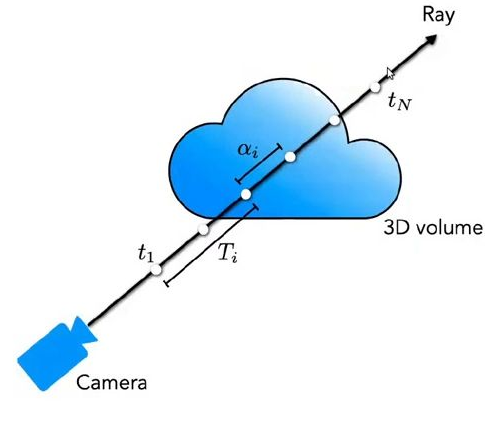

In [27]:
# Redundant vector
one_e_10 = torch.tensor([1e10]).to(rayOrigins)
one_e_10 = one_e_10.expand(depth_scalars_ray_samples[..., :1].shape) # (num_rays, 1)

# We get the distance between adjacent sample points,
# but notice that the last sample points of each ray would not have corresponding distance, we set it to be
# a large value (1e10), so that it's approximately zero when `exp(-1e10 * sigma)`
delta = depth_scalars_ray_samples[..., 1:] - depth_scalars_ray_samples[..., :-1] # (num_rays, num_samples-1)
delta = torch.cat((delta, one_e_10), dim=-1) # (num_rays, num_samples)
delta.shape

torch.Size([160000, 4])

In [28]:
# Alpha: how much light is contributed by each sampled point on ray to the overall color of the pixel
# Calculating `alpha = 1−exp(−𝜎𝛿)`
alpha = 1. - torch.exp(-sigma * delta)  # (num_rays, num_samples)
alpha.shape, alpha

(torch.Size([160000, 4]),
 tensor([[0.0000, 0.0000, 0.0250, 1.0000],
         [0.0000, 0.0000, 0.0330, 1.0000],
         [0.0000, 0.0000, 0.0582, 1.0000],
         ...,
         [0.0868, 0.0176, 0.0479, 1.0000],
         [0.0832, 0.0219, 0.0512, 1.0000],
         [0.0200, 0.1525, 0.0751, 1.0000]], device='cuda:0',
        grad_fn=<RsubBackward1>))

In [29]:
q = torch.arange(0,12,1).view(4, 3)
q, torch.cumprod(q, dim=0), torch.roll(q, shifts=1, dims=-1), torch.roll(q, shifts=-1, dims=0)

(tensor([[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8],
         [ 9, 10, 11]]),
 tensor([[  0,   1,   2],
         [  0,   4,  10],
         [  0,  28,  80],
         [  0, 280, 880]]),
 tensor([[ 2,  0,  1],
         [ 5,  3,  4],
         [ 8,  6,  7],
         [11,  9, 10]]),
 tensor([[ 3,  4,  5],
         [ 6,  7,  8],
         [ 9, 10, 11],
         [ 0,  1,  2]]))

In [30]:
# Transmittance weight : how much light is blocked earlier along ray
# Calculate transmittance value, notice that T_1 = 1
# It's possible that we get alpha=1 (sigma=0) for point A, which could make
# transmittance of all the points after point A to be 0, we also want to take
# their information into consideration, therefore we add a small value (1e-10)
# to avoid vanishing transmittance
def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    """Mimick functionality of tf.math.cumprod(..., exclusive=True)

    Args:
      tensor: tensor whose cumulative product along dim=-1 is to be computed.
    
    Returns:
      cumprod: cumprod of Tensor along dim=-1
    """
    # cumprod = (tensor[0], tensor[0]*tensor[1], tensor[0]*tensor[1]*tensor[2], ...)
    cumprod = torch.cumprod(tensor, dim=-1)
    print(f'after cumprod:\n{cumprod}')

    # Roll down the elements along dimension 'dim' by 1 element.
    cumprod = torch.roll(cumprod, shifts=1, dims=-1)
    print(f'after roll:\n{cumprod}')

    # cumprod = (1, tensor[0], tensor[0]*tensor[1], ...)
    cumprod[..., 0] = 1.
   
    return cumprod

In [31]:
trans = cumprod_exclusive(1. - alpha + 1e-10) # (num_rays, num_samples)
trans.shape, trans

after cumprod:
tensor([[1.0000e+00, 1.0000e+00, 9.7499e-01, 9.7499e-11],
        [1.0000e+00, 1.0000e+00, 9.6700e-01, 9.6700e-11],
        [1.0000e+00, 1.0000e+00, 9.4185e-01, 9.4185e-11],
        ...,
        [9.1324e-01, 8.9719e-01, 8.5424e-01, 8.5424e-11],
        [9.1678e-01, 8.9671e-01, 8.5081e-01, 8.5081e-11],
        [9.8004e-01, 8.3056e-01, 7.6822e-01, 7.6822e-11]], device='cuda:0',
       grad_fn=<CumprodBackward0>)
after roll:
tensor([[9.7499e-11, 1.0000e+00, 1.0000e+00, 9.7499e-01],
        [9.6700e-11, 1.0000e+00, 1.0000e+00, 9.6700e-01],
        [9.4185e-11, 1.0000e+00, 1.0000e+00, 9.4185e-01],
        ...,
        [8.5424e-11, 9.1324e-01, 8.9719e-01, 8.5424e-01],
        [8.5081e-11, 9.1678e-01, 8.9671e-01, 8.5081e-01],
        [7.6822e-11, 9.8004e-01, 8.3056e-01, 7.6822e-01]], device='cuda:0',
       grad_fn=<RollBackward0>)


(torch.Size([160000, 4]),
 tensor([[1.0000, 1.0000, 1.0000, 0.9750],
         [1.0000, 1.0000, 1.0000, 0.9670],
         [1.0000, 1.0000, 1.0000, 0.9418],
         ...,
         [1.0000, 0.9132, 0.8972, 0.8542],
         [1.0000, 0.9168, 0.8967, 0.8508],
         [1.0000, 0.9800, 0.8306, 0.7682]], device='cuda:0',
        grad_fn=<CopySlices>))

In [32]:
weights = alpha * trans # (num_rays, num_samples)
print(weights.shape, weights)
# overall color in that pixel = sum ( w * rgb of each sampled point)
# (num_rays, num_samples, 1) * (num_rays, num_samples, 3) -> (num_rays, num_samples, 3)
rgb_map = (weights[..., None] * rgb).sum(dim=-2) # (num_rays, 3)
rgb_map = rgb_map.contiguous().view(H, W, 3) # (H, W, 3)
rgb_map.shape, rgb_map

torch.Size([160000, 4]) tensor([[0.0000, 0.0000, 0.0250, 0.9750],
        [0.0000, 0.0000, 0.0330, 0.9670],
        [0.0000, 0.0000, 0.0582, 0.9418],
        ...,
        [0.0868, 0.0161, 0.0429, 0.8542],
        [0.0832, 0.0201, 0.0459, 0.8508],
        [0.0200, 0.1495, 0.0623, 0.7682]], device='cuda:0',
       grad_fn=<MulBackward0>)


(torch.Size([400, 400, 3]),
 tensor([[[0.5187, 0.4533, 0.4434],
          [0.5176, 0.4526, 0.4412],
          [0.5180, 0.4548, 0.4412],
          ...,
          [0.5044, 0.4649, 0.4450],
          [0.5055, 0.4656, 0.4463],
          [0.5053, 0.4643, 0.4452]],
 
         [[0.5184, 0.4537, 0.4412],
          [0.5195, 0.4557, 0.4446],
          [0.5173, 0.4547, 0.4412],
          ...,
          [0.5046, 0.4752, 0.4312],
          [0.5021, 0.4733, 0.4228],
          [0.5074, 0.4583, 0.4462]],
 
         [[0.5167, 0.4531, 0.4407],
          [0.5179, 0.4611, 0.4477],
          [0.5173, 0.4555, 0.4399],
          ...,
          [0.5031, 0.4660, 0.4449],
          [0.5030, 0.4746, 0.4362],
          [0.5076, 0.4600, 0.4475]],
 
         ...,
 
         [[0.5108, 0.4755, 0.4574],
          [0.5048, 0.4758, 0.4587],
          [0.5147, 0.4745, 0.4598],
          ...,
          [0.5155, 0.5035, 0.4692],
          [0.5169, 0.5006, 0.4729],
          [0.5173, 0.4995, 0.4722]],
 
         [[0.5039, 0

In [33]:
# overall depth in that pixel = sum ( w * depth of each sampled point)
# (num_rays, num_samples) * (num_rays, num_samples) -> (num_rays, num_samples)
depth_map = (weights * depth_scalars_ray_samples).sum(dim=-1) # (num_rays)
depth_map = depth_map.contiguous().view(H, W) # (H, W)
depth_map.shape , depth_map

(torch.Size([400, 400]),
 tensor([[6.4748, 6.0738, 6.1814,  ..., 6.1694, 6.0057, 6.0980],
         [6.1034, 5.8697, 6.3170,  ..., 6.4381, 6.6857, 5.9621],
         [6.0319, 6.7660, 6.1751,  ..., 6.1730, 6.4218, 5.9361],
         ...,
         [6.2972, 6.2072, 5.7466,  ..., 6.3003, 6.4340, 6.6420],
         [6.5498, 6.7751, 6.5797,  ..., 6.2627, 6.2164, 5.8543],
         [6.0590, 6.2568, 6.5500,  ..., 5.9226, 6.0067, 6.2128]],
        device='cuda:0', grad_fn=<ViewBackward0>))

In [34]:
# accumulated transmittance map
accum_transmit = weights.sum(-1) # (num_rays)
accum_transmit = accum_transmit.contiguous().view(H, W) # (H, W)
accum_transmit.shape , accum_transmit

(torch.Size([400, 400]),
 tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
        device='cuda:0', grad_fn=<ViewBackward0>))

# Loss

In [35]:
images[0, ... , :3].shape

torch.Size([400, 400, 3])

In [37]:
# Compute mean-squared error between the predicted and target images
loss = torch.nn.functional.mse_loss(rgb_map, images[img_idx, ... , :3])
psnr = -10. * torch.log10(loss)
loss, psnr

(tensor(0.1459, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(8.3581, device='cuda:0', grad_fn=<MulBackward0>))